In [2]:
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

import os, sys
import time

import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt, colors

from pathlib import Path
from multiprocessing.pool import ThreadPool

import PIL
from PIL import Image
from skimage import io

from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import transforms

from tqdm import tqdm, tqdm_notebook

import pickle
import copy

In [3]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

DEVICE

device(type='cuda')

In [4]:
# детерминируем состояния
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Preparing the Data

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/

Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:

$input = \frac{input - \mu}{\text{standard deviation}} $,

константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

## Class for loading the data from folders in parallel

In [5]:
class SimpsonsDataset(Dataset):
    """
    Class to work with image dastaset, which
    - loads them form the folders in parallel
    - converts to PyTorch tensors
    - scales the tensors to have mean = 0, standard deviation = 1
    """
    def __init__(self, files, mode):
        super().__init__()
        self.files = sorted(files) # list of files to be loaded
        self.mode = mode           # working mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                
    
    def __len__(self):
        return self.len_
    
    
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
    
    
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)
    
    
    def __getitem__(self, index):
        # предобработка изображений и каст к тензору
        data_transforms = {
            'train': transforms.Compose([
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.RandomRotation(degrees=30),
                transforms.RandomHorizontalFlip(),
                transforms.ColorJitter(hue=.1, saturation=.1),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ]),
            'val_test': transforms.Compose([
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ]),
        }

        transform = (data_transforms['train'] if self.mode == 'train' else data_transforms['val_test'])
        
        x = self.load_sample(self.files[index])  # load image
        x = transform(x)                         # apply transform defined above
        
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        

In [6]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [7]:
from pathlib import Path

# подгружаем имена картинок
TRAIN_DIR = Path('../input/journey-springfield/train/simpsons_dataset/')
TEST_DIR = Path('../input/journey-springfield/testset/testset/')

train_val_files = sorted(list(TRAIN_DIR.rglob('*/*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

train_val_labels = [path.parent.name for path in train_val_files]

# Training

In [8]:
#  Делим выборку на обучающую и валидационную
from sklearn.model_selection import train_test_split

train_files, val_files = train_test_split(train_val_files, test_size=0.20, stratify=train_val_labels)
val_dataset = SimpsonsDataset(val_files, mode='val')

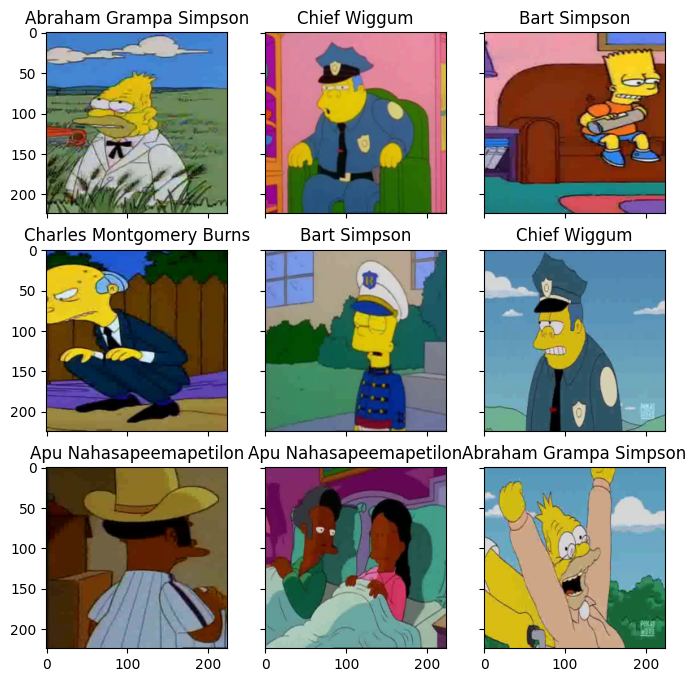

In [9]:
# смотрим на произвольные картинки из датасета
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)

for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

# Functions for training

In [10]:
def fit_epoch(model, train_loader, criterion, optimizer):
    # инициализируем начальные лоссы
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        
        # обнуляем градиент
        optimizer.zero_grad()
        
        # forward + backward
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        # обновляем веса
        optimizer.step()
        
        # получаем предсказание на обновленных весах и записывем лосс
        preds = torch.argmax(outputs, 1)
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
                
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [11]:
def eval_epoch(model, val_loader, criterion):
    # переводим модель в режим необучения
    model.eval()
    
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
        
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [12]:
def train(train_dataset, val_dataset, model, criterion,
          epochs, batch_size, optimizer, scheduler,
          shuffle=True, sampler=None, patience=5):
    
    # для получения времени обучения
    start = time.time()
    
    # загружаем данные для обучения и валидации
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, sampler=sampler, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    # init variables to store best model weights, best accuracy, best epoch number, epochs since best accuracy acheived
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10
    best_epoch = 0
    epochs_since_best = 0
    
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:

        for epoch in range(1, epochs+1):
            print(f"epoch {epoch}:\n")
            
            print("Fitting on train data...")
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer)
            print("train loss:", train_loss)
            
            print("Evaluating on validation data...")
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            print("val loss:", val_loss)
            
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            # update learning rate
            scheduler.step()
            
            # display learning status
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
            # сохранение модели при достижении лучшего лосса
            if val_loss < best_loss:
                best_acc = val_loss
                best_epoch = epoch
                best_model_wts = copy.deepcopy(model.state_dict())
                print()
            else:
                epochs_since_best += 1
            
            if epochs_since_best > patience:
                print(f'Stopping training. The validation metric has not improved for {patience} epochs.')
                break
            
        
    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))
    print('Best epoch: {}'.format(best_epoch))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
            
    return history

In [13]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
        
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

# Training: fine-tuning pretrained 

In [14]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [15]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=e09ed8ef0256ee1f320ab3f88983e990e15863d296633b92412f4e31268ee7f7
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [16]:
from efficientnet_pytorch import EfficientNet 

model_name = 'efficientnet-b2'
model = EfficientNet.from_pretrained(model_name)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b2-8bb594d6.pth
100%|██████████| 35.1M/35.1M [00:00<00:00, 216MB/s]


Loaded pretrained weights for efficientnet-b2


In [17]:
# меняем количество выходов
N_CLASSES = len(np.unique(train_val_labels))

for param in model.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model._fc.in_features
model._fc = nn.Linear(num_ftrs, N_CLASSES)

model = model.to(DEVICE)

# loss
criterion = nn.CrossEntropyLoss()

# learning rate optimizer
optimizer = torch.optim.AdamW(model.parameters())

# scheduler for the lr optimizer
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 3, 0.5)

In [18]:
# обучаем выходной слой
history_feature_extr = train(train_dataset, val_dataset, model=model, criterion=criterion,
                             epochs=3, batch_size=256, optimizer=optimizer, scheduler=scheduler)

epoch:   0%|          | 0/3 [00:00<?, ?it/s]

epoch 1:

Fitting on train data...
train loss: 2.8092947729767457
Evaluating on validation data...


epoch:  33%|███▎      | 1/3 [01:39<03:19, 99.75s/it]

val loss: 2.476432556407902

Epoch 001 train_loss: 2.8093     val_loss 2.4764 train_acc 0.3231 val_acc 0.4268

epoch 2:

Fitting on train data...
train loss: 2.034433997732386
Evaluating on validation data...


epoch:  67%|██████▋   | 2/3 [03:00<01:28, 88.40s/it]

val loss: 1.7397969483702855

Epoch 002 train_loss: 2.0344     val_loss 1.7398 train_acc 0.5481 val_acc 0.6176

epoch 3:

Fitting on train data...
train loss: 1.5944294793253002
Evaluating on validation data...


epoch: 100%|██████████| 3/3 [04:25<00:00, 88.34s/it]

val loss: 1.4699498787113041

Epoch 003 train_loss: 1.5944     val_loss 1.4699 train_acc 0.6270 val_acc 0.6606

Training complete in 4m 25s
Best val loss: 10.000000
Best epoch: 3


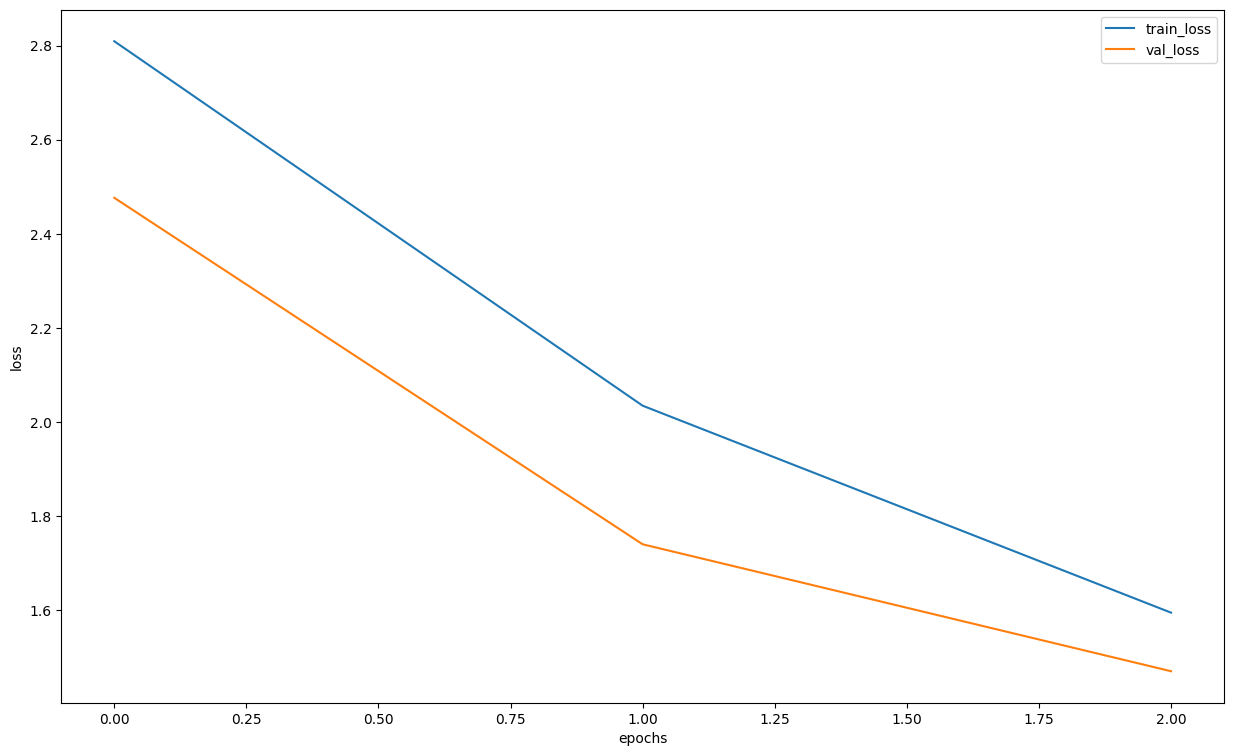

In [19]:
loss, acc, val_loss, val_acc = zip(*history_feature_extr)

plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [20]:
# обучаем все слои
for param in model.parameters():
    param.requires_grad = True

In [21]:
history_fine_tune = train(train_dataset=train_dataset, val_dataset=val_dataset, model=model, criterion=criterion,
                          epochs=50, batch_size=16, optimizer=optimizer, scheduler=scheduler)

epoch:   0%|          | 0/50 [00:00<?, ?it/s]

epoch 1:

Fitting on train data...
train loss: 0.46244660428063705
Evaluating on validation data...


epoch:   2%|▏         | 1/50 [02:26<1:59:23, 146.18s/it]

val loss: 0.22766332643461137

Epoch 001 train_loss: 0.4624     val_loss 0.2277 train_acc 0.8804 val_acc 0.9412

epoch 2:

Fitting on train data...
train loss: 0.2513085504358733
Evaluating on validation data...


epoch:   4%|▍         | 2/50 [04:49<1:55:32, 144.44s/it]

val loss: 0.22308470792729512

Epoch 002 train_loss: 0.2513     val_loss 0.2231 train_acc 0.9347 val_acc 0.9410

epoch 3:

Fitting on train data...
train loss: 0.18684290399319758
Evaluating on validation data...


epoch:   6%|▌         | 3/50 [07:19<1:55:15, 147.14s/it]

val loss: 0.18948168862432319

Epoch 003 train_loss: 0.1868     val_loss 0.1895 train_acc 0.9519 val_acc 0.9518

epoch 4:

Fitting on train data...
train loss: 0.06623207470515714
Evaluating on validation data...


epoch:   8%|▊         | 4/50 [09:42<1:51:27, 145.38s/it]

val loss: 0.11854068040831607

Epoch 004 train_loss: 0.0662     val_loss 0.1185 train_acc 0.9826 val_acc 0.9756

epoch 5:

Fitting on train data...
train loss: 0.061476824899077076
Evaluating on validation data...


epoch:  10%|█         | 5/50 [12:04<1:48:07, 144.16s/it]

val loss: 0.12350127751071228

Epoch 005 train_loss: 0.0615     val_loss 0.1235 train_acc 0.9841 val_acc 0.9733

epoch 6:

Fitting on train data...
train loss: 0.0548189929649364
Evaluating on validation data...


epoch:  12%|█▏        | 6/50 [14:25<1:44:51, 142.98s/it]

val loss: 0.14582856448015835

Epoch 006 train_loss: 0.0548     val_loss 0.1458 train_acc 0.9852 val_acc 0.9673

epoch 7:

Fitting on train data...
train loss: 0.02246101882617115
Evaluating on validation data...


epoch:  14%|█▍        | 7/50 [16:45<1:41:53, 142.17s/it]

val loss: 0.10237909406647744

Epoch 007 train_loss: 0.0225     val_loss 0.1024 train_acc 0.9943 val_acc 0.9811

epoch 8:

Fitting on train data...
train loss: 0.014817129209598321
Evaluating on validation data...


epoch:  16%|█▌        | 8/50 [19:06<1:39:10, 141.67s/it]

val loss: 0.11532385574213037

Epoch 008 train_loss: 0.0148     val_loss 0.1153 train_acc 0.9959 val_acc 0.9764

epoch 9:

Fitting on train data...
train loss: 0.01642815615456501
Evaluating on validation data...


epoch:  18%|█▊        | 9/50 [21:27<1:36:43, 141.55s/it]

val loss: 0.1366734764413809

Epoch 009 train_loss: 0.0164     val_loss 0.1367 train_acc 0.9950 val_acc 0.9761

epoch 10:

Fitting on train data...
train loss: 0.0064288514538384176
Evaluating on validation data...


epoch:  20%|██        | 10/50 [23:48<1:34:14, 141.36s/it]

val loss: 0.13659838427725296

Epoch 010 train_loss: 0.0064     val_loss 0.1366 train_acc 0.9982 val_acc 0.9768

epoch 11:

Fitting on train data...
train loss: 0.005872591153790887
Evaluating on validation data...


epoch:  22%|██▏       | 11/50 [26:08<1:31:39, 141.01s/it]

val loss: 0.11951074508273425

Epoch 011 train_loss: 0.0059     val_loss 0.1195 train_acc 0.9983 val_acc 0.9790

epoch 12:

Fitting on train data...
train loss: 0.004137104686484008
Evaluating on validation data...


epoch:  24%|██▍       | 12/50 [28:29<1:29:19, 141.03s/it]

val loss: 0.1270781729733559

Epoch 012 train_loss: 0.0041     val_loss 0.1271 train_acc 0.9985 val_acc 0.9818

epoch 13:

Fitting on train data...
train loss: 0.0025120872227958214
Evaluating on validation data...


epoch:  26%|██▌       | 13/50 [30:52<1:27:18, 141.59s/it]

val loss: 0.12143415028770274

Epoch 013 train_loss: 0.0025     val_loss 0.1214 train_acc 0.9992 val_acc 0.9811

epoch 14:

Fitting on train data...
train loss: 0.0007996375322635737
Evaluating on validation data...


epoch:  28%|██▊       | 14/50 [33:17<1:25:27, 142.44s/it]

val loss: 0.1271997325284226

Epoch 014 train_loss: 0.0008     val_loss 0.1272 train_acc 0.9997 val_acc 0.9818

epoch 15:

Fitting on train data...
train loss: 0.0023492960239889604
Evaluating on validation data...


epoch:  30%|███       | 15/50 [35:38<1:22:56, 142.20s/it]

val loss: 0.11482596928993305

Epoch 015 train_loss: 0.0023     val_loss 0.1148 train_acc 0.9992 val_acc 0.9826

epoch 16:

Fitting on train data...
train loss: 0.0021676796790725595
Evaluating on validation data...


epoch:  32%|███▏      | 16/50 [37:59<1:20:18, 141.73s/it]

val loss: 0.11106869909228843

Epoch 016 train_loss: 0.0022     val_loss 0.1111 train_acc 0.9993 val_acc 0.9833

epoch 17:

Fitting on train data...
train loss: 0.000943981961960009
Evaluating on validation data...


epoch:  34%|███▍      | 17/50 [40:23<1:18:20, 142.43s/it]

val loss: 0.11185770086866215

Epoch 017 train_loss: 0.0009     val_loss 0.1119 train_acc 0.9998 val_acc 0.9835

epoch 18:

Fitting on train data...
train loss: 0.0008141209657263159
Evaluating on validation data...


epoch:  36%|███▌      | 18/50 [42:43<1:15:38, 141.83s/it]

val loss: 0.11449205698713437

Epoch 018 train_loss: 0.0008     val_loss 0.1145 train_acc 0.9996 val_acc 0.9845

epoch 19:

Fitting on train data...
train loss: 0.0008612816700159764
Evaluating on validation data...


epoch:  38%|███▊      | 19/50 [45:06<1:13:22, 142.00s/it]

val loss: 0.12046444563497154

Epoch 019 train_loss: 0.0009     val_loss 0.1205 train_acc 0.9996 val_acc 0.9833

epoch 20:

Fitting on train data...
train loss: 0.0006218722633641127
Evaluating on validation data...


epoch:  40%|████      | 20/50 [47:26<1:10:43, 141.44s/it]

val loss: 0.12148556985993646

Epoch 020 train_loss: 0.0006     val_loss 0.1215 train_acc 0.9998 val_acc 0.9845

epoch 21:

Fitting on train data...
train loss: 0.000550993850835845
Evaluating on validation data...


epoch:  42%|████▏     | 21/50 [49:47<1:08:22, 141.46s/it]

val loss: 0.125970007794867

Epoch 021 train_loss: 0.0006     val_loss 0.1260 train_acc 0.9997 val_acc 0.9835

epoch 22:

Fitting on train data...
train loss: 0.0007127713497183595
Evaluating on validation data...


epoch:  44%|████▍     | 22/50 [52:08<1:05:54, 141.22s/it]

val loss: 0.12370152444865629

Epoch 022 train_loss: 0.0007     val_loss 0.1237 train_acc 0.9997 val_acc 0.9845

epoch 23:

Fitting on train data...
train loss: 0.00045725780266302006
Evaluating on validation data...


epoch:  46%|████▌     | 23/50 [54:29<1:03:29, 141.09s/it]

val loss: 0.12421036758749053

Epoch 023 train_loss: 0.0005     val_loss 0.1242 train_acc 0.9998 val_acc 0.9845

epoch 24:

Fitting on train data...
train loss: 0.0008659972589453378
Evaluating on validation data...


epoch:  48%|████▊     | 24/50 [56:49<1:01:00, 140.79s/it]

val loss: 0.12376974286772405

Epoch 024 train_loss: 0.0009     val_loss 0.1238 train_acc 0.9998 val_acc 0.9840

epoch 25:

Fitting on train data...
train loss: 0.0004749860128265819
Evaluating on validation data...


epoch:  50%|█████     | 25/50 [59:10<58:41, 140.85s/it]  

val loss: 0.12266606617907702

Epoch 025 train_loss: 0.0005     val_loss 0.1227 train_acc 0.9998 val_acc 0.9840

epoch 26:

Fitting on train data...
train loss: 0.00017525295502312597
Evaluating on validation data...


epoch:  52%|█████▏    | 26/50 [1:01:31<56:21, 140.91s/it]

val loss: 0.12292424093969469

Epoch 026 train_loss: 0.0002     val_loss 0.1229 train_acc 1.0000 val_acc 0.9840

epoch 27:

Fitting on train data...
train loss: 0.00025747607867492245
Evaluating on validation data...


epoch:  54%|█████▍    | 27/50 [1:03:52<53:59, 140.85s/it]

val loss: 0.12360760267533363

Epoch 027 train_loss: 0.0003     val_loss 0.1236 train_acc 0.9999 val_acc 0.9840

epoch 28:

Fitting on train data...
train loss: 0.000878317183343488
Evaluating on validation data...


epoch:  56%|█████▌    | 28/50 [1:06:13<51:40, 140.94s/it]

val loss: 0.12383089518201638

Epoch 028 train_loss: 0.0009     val_loss 0.1238 train_acc 0.9998 val_acc 0.9838

epoch 29:

Fitting on train data...
train loss: 0.00029166971526390365
Evaluating on validation data...


epoch:  58%|█████▊    | 29/50 [1:08:33<49:17, 140.82s/it]

val loss: 0.12385738166747666

Epoch 029 train_loss: 0.0003     val_loss 0.1239 train_acc 0.9999 val_acc 0.9840

epoch 30:

Fitting on train data...
train loss: 0.00032866556521286117
Evaluating on validation data...


epoch:  60%|██████    | 30/50 [1:10:54<46:55, 140.78s/it]

val loss: 0.12373098888355975

Epoch 030 train_loss: 0.0003     val_loss 0.1237 train_acc 0.9999 val_acc 0.9840

epoch 31:

Fitting on train data...
train loss: 0.00041082726311004433
Evaluating on validation data...


epoch:  62%|██████▏   | 31/50 [1:13:15<44:33, 140.70s/it]

val loss: 0.12363195915830873

Epoch 031 train_loss: 0.0004     val_loss 0.1236 train_acc 0.9999 val_acc 0.9838

epoch 32:

Fitting on train data...
train loss: 0.00044341265468811217
Evaluating on validation data...


epoch:  64%|██████▍   | 32/50 [1:15:35<42:14, 140.78s/it]

val loss: 0.12382296304527227

Epoch 032 train_loss: 0.0004     val_loss 0.1238 train_acc 0.9998 val_acc 0.9838

epoch 33:

Fitting on train data...
train loss: 0.00047916214284893883
Evaluating on validation data...


epoch:  66%|██████▌   | 33/50 [1:17:58<39:59, 141.17s/it]

val loss: 0.1235531534102933

Epoch 033 train_loss: 0.0005     val_loss 0.1236 train_acc 0.9997 val_acc 0.9838

epoch 34:

Fitting on train data...
train loss: 0.00028318375366037706
Evaluating on validation data...


epoch:  68%|██████▊   | 34/50 [1:20:20<37:42, 141.43s/it]

val loss: 0.12369187160605592

Epoch 034 train_loss: 0.0003     val_loss 0.1237 train_acc 0.9999 val_acc 0.9835

epoch 35:

Fitting on train data...
train loss: 0.0004138031010056408
Evaluating on validation data...


epoch:  70%|███████   | 35/50 [1:22:41<35:21, 141.42s/it]

val loss: 0.1237297502664991

Epoch 035 train_loss: 0.0004     val_loss 0.1237 train_acc 0.9998 val_acc 0.9835

epoch 36:

Fitting on train data...
train loss: 0.00039165639333213687
Evaluating on validation data...


epoch:  72%|███████▏  | 36/50 [1:25:03<33:00, 141.46s/it]

val loss: 0.12376867732594683

Epoch 036 train_loss: 0.0004     val_loss 0.1238 train_acc 0.9998 val_acc 0.9835

epoch 37:

Fitting on train data...
train loss: 0.00028792885837118713
Evaluating on validation data...


epoch:  74%|███████▍  | 37/50 [1:27:23<30:35, 141.21s/it]

val loss: 0.12377565164060764

Epoch 037 train_loss: 0.0003     val_loss 0.1238 train_acc 0.9999 val_acc 0.9835

epoch 38:

Fitting on train data...
train loss: 0.00035340999647047835
Evaluating on validation data...


epoch:  76%|███████▌  | 38/50 [1:29:44<28:14, 141.22s/it]

val loss: 0.12375276783034235

Epoch 038 train_loss: 0.0004     val_loss 0.1238 train_acc 0.9999 val_acc 0.9835

epoch 39:

Fitting on train data...
train loss: 0.00024301802188565042
Evaluating on validation data...


epoch:  78%|███████▊  | 39/50 [1:32:06<25:54, 141.35s/it]

val loss: 0.12381353737343662

Epoch 039 train_loss: 0.0002     val_loss 0.1238 train_acc 0.9999 val_acc 0.9835

epoch 40:

Fitting on train data...
train loss: 0.00037919204275833695
Evaluating on validation data...


epoch:  80%|████████  | 40/50 [1:34:27<23:30, 141.10s/it]

val loss: 0.12378467235823493

Epoch 040 train_loss: 0.0004     val_loss 0.1238 train_acc 0.9999 val_acc 0.9835

epoch 41:

Fitting on train data...
train loss: 0.0003208801878621387
Evaluating on validation data...


epoch:  82%|████████▏ | 41/50 [1:36:47<21:09, 141.01s/it]

val loss: 0.12378319389625672

Epoch 041 train_loss: 0.0003     val_loss 0.1238 train_acc 0.9998 val_acc 0.9835

epoch 42:

Fitting on train data...
train loss: 0.0004592135086932847
Evaluating on validation data...


epoch:  84%|████████▍ | 42/50 [1:39:08<18:48, 141.00s/it]

val loss: 0.1237563259610575

Epoch 042 train_loss: 0.0005     val_loss 0.1238 train_acc 0.9997 val_acc 0.9838

epoch 43:

Fitting on train data...
train loss: 0.00033005487736433123
Evaluating on validation data...


epoch:  86%|████████▌ | 43/50 [1:41:29<16:26, 141.00s/it]

val loss: 0.12376919903444573

Epoch 043 train_loss: 0.0003     val_loss 0.1238 train_acc 0.9998 val_acc 0.9838

epoch 44:

Fitting on train data...
train loss: 0.0004423830161833487
Evaluating on validation data...


epoch:  88%|████████▊ | 44/50 [1:43:50<14:05, 140.97s/it]

val loss: 0.12375901676884715

Epoch 044 train_loss: 0.0004     val_loss 0.1238 train_acc 0.9998 val_acc 0.9838

epoch 45:

Fitting on train data...
train loss: 0.00027568224980663547
Evaluating on validation data...


epoch:  90%|█████████ | 45/50 [1:46:11<11:45, 141.05s/it]

val loss: 0.12376349096761667

Epoch 045 train_loss: 0.0003     val_loss 0.1238 train_acc 0.9999 val_acc 0.9838

epoch 46:

Fitting on train data...
train loss: 0.00035936710522313693
Evaluating on validation data...


epoch:  92%|█████████▏| 46/50 [1:48:32<09:24, 141.01s/it]

val loss: 0.12376084725677809

Epoch 046 train_loss: 0.0004     val_loss 0.1238 train_acc 0.9998 val_acc 0.9838

epoch 47:

Fitting on train data...
train loss: 0.00017813372962782913
Evaluating on validation data...


epoch:  94%|█████████▍| 47/50 [1:50:54<07:03, 141.27s/it]

val loss: 0.12376277931293773

Epoch 047 train_loss: 0.0002     val_loss 0.1238 train_acc 1.0000 val_acc 0.9838

epoch 48:

Fitting on train data...
train loss: 0.00015877718704722062
Evaluating on validation data...


epoch:  96%|█████████▌| 48/50 [1:53:16<04:42, 141.44s/it]

val loss: 0.12377075401271534

Epoch 048 train_loss: 0.0002     val_loss 0.1238 train_acc 1.0000 val_acc 0.9838

epoch 49:

Fitting on train data...
train loss: 0.0003422786412172412
Evaluating on validation data...


epoch:  98%|█████████▊| 49/50 [1:55:37<02:21, 141.35s/it]

val loss: 0.1237703989140978

Epoch 049 train_loss: 0.0003     val_loss 0.1238 train_acc 0.9998 val_acc 0.9838

epoch 50:

Fitting on train data...
train loss: 0.0002854358991394387
Evaluating on validation data...


epoch: 100%|██████████| 50/50 [1:58:03<00:00, 141.67s/it]

val loss: 0.12377118561014651

Epoch 050 train_loss: 0.0003     val_loss 0.1238 train_acc 0.9999 val_acc 0.9838

Training complete in 118m 4s
Best val loss: 10.000000
Best epoch: 50


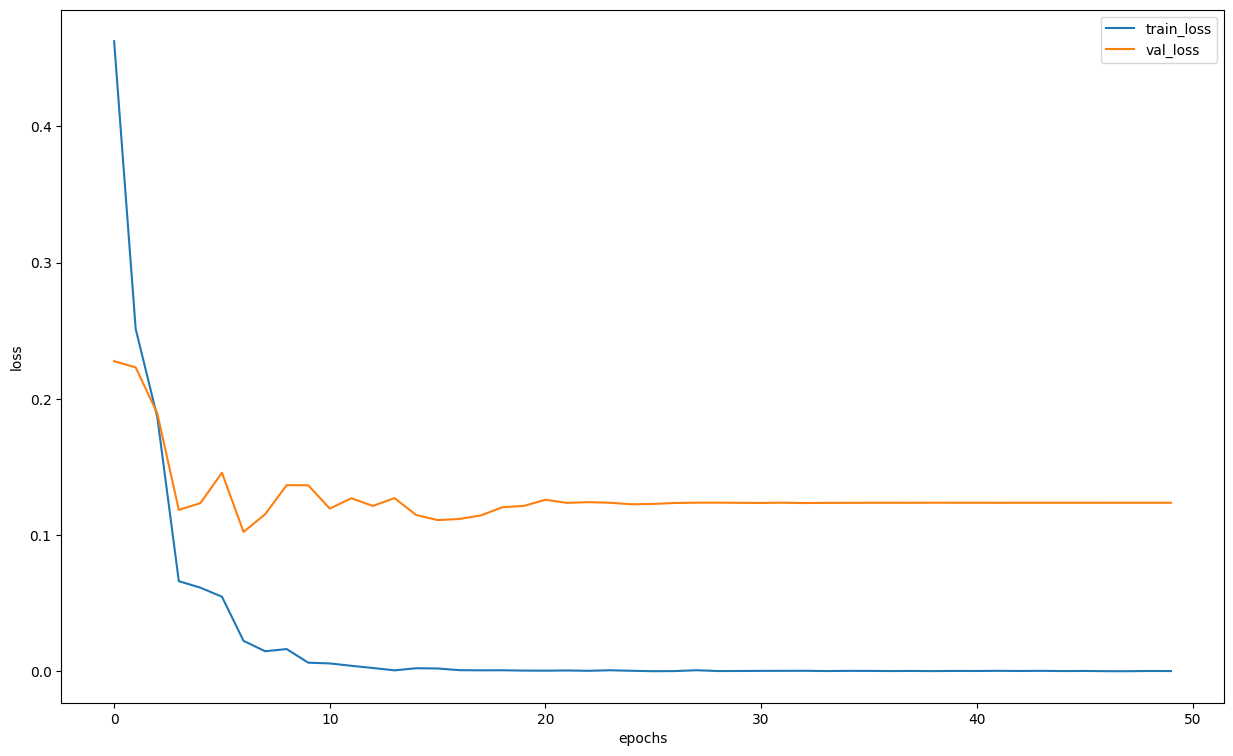

In [22]:
# смотрим как менялся лосс
loss, acc, val_loss, val_acc = zip(*history_fine_tune)

plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")

plt.show()

In [23]:
# save the weights of our net
model_weights = copy.deepcopy(model.state_dict())
torch.save(model_weights, f"{model_name}_weights.pth")

# загружаем сохраненное состояние весов нейросети
model.load_state_dict(torch.load(f"{model_name}_weights.pth"))

<All keys matched successfully>

# What now?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит. 
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [24]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [25]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model, ex_img.unsqueeze(0))

In [26]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)

## Compare actual and predicted class ids

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе - f1-score. Вычислим целевую метрику на валидационной выборке.

In [27]:
from sklearn.metrics import f1_score

actual_labels = [val_dataset[id][1] for id in idxs]
y_pred = np.argmax(probs_ims, -1)

f1_score(actual_labels, y_pred, average='weighted')

0.9727272727272727

## Compare actual and predicted classes (strings)

In [28]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

actual_class = [label_encoder.classes_[i] for i in actual_labels]
preds_class = [label_encoder.classes_[i] for i in y_pred]

f1_score(actual_class, preds_class, average='weighted')

0.9727272727272727

Сделаем классную визуализацию, чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

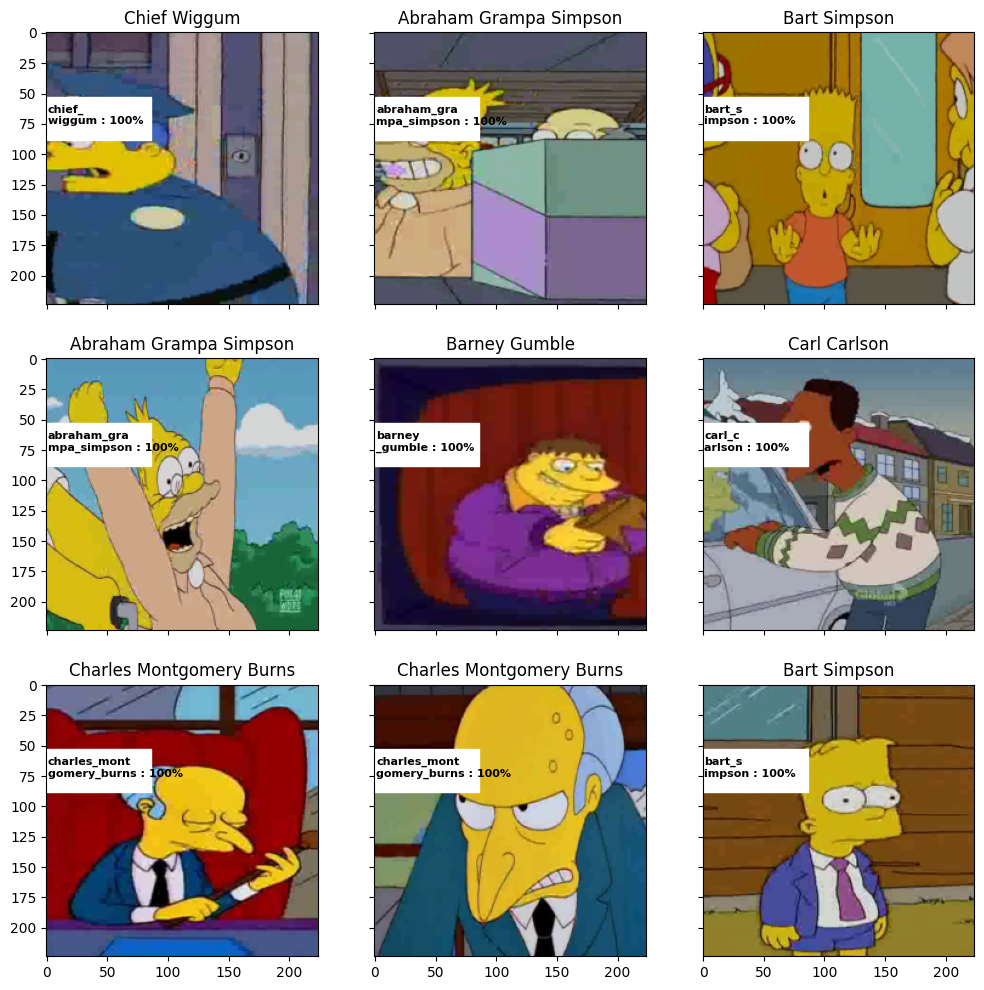

In [29]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

# Submit to Kaggle competition

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [30]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64, num_workers=4)
probs = predict(model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

# Check how the sample submission file looks

In [31]:
import pandas as pd
sample_submit = pd.read_csv("../input/journey-springfield/sample_submission.csv")
sample_submit.head()

,Id,Expected
0,img0.jpg,bart_simpson
1,img1.jpg,bart_simpson
2,img2.jpg,bart_simpson
3,img3.jpg,bart_simpson
4,img4.jpg,bart_simpson


In [32]:
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
print(my_submit.shape)
my_submit.head()

(991, 2)


,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [34]:
my_submit.to_csv(f"{model_name}_submission.csv", index=False)